# Random Forest Analysis
by Vinod George

***Remember:***

This project aims to predict NFL team success (win/loss outcomes) based on performance metrics from games spanning the 2002–2019 NFL seasons. The dataset contains critical game-related features such as yardage, turnovers, points scored, possession time, and red zone efficiency. These metrics provide a view of a team’s offensive and defensive performance.

So, using Random Forest, the model will:

**1. Classify NFL games into win (1) or loss (0) categories for the home team.**

**2. Highlight the most influential features that determine team success.**

**3. Provide a baseline evaluation for further optimization or comparison with other models.** 

Let's start by importing essential libraries for data processing, visualization, and modeling. Then, we load the cleaned dataset for analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset  
data = pd.read_csv("../data/cleaned_nfl_team_stats.csv")

# Display dataset overview
print("Dataset Overview:")
print(data.head())
print(data.info())

# Check the distribution of the target variable
print("Target Variable Distribution (win_loss_home):")
print(data['win_loss_home'].value_counts(normalize=True))


Dataset Overview:
   season week       away        home  score_away  score_home  \
0    2002    1      49ers      Giants          16          13   
1    2002    1      Colts     Jaguars          28          25   
2    2002    1  Cardinals  Commanders          23          31   
3    2002    1      Lions    Dolphins          21          49   
4    2002    1     Eagles      Titans          24          27   

   first_downs_away  first_downs_home  first_downs_from_passing_away  \
0                13                21                              7   
1                18                19                             13   
2                14                21                              9   
3                15                27                             10   
4                17                22                             11   

   first_downs_from_passing_home  ...  def_st_td_home  possession_away  \
0                             17  ...               0             1652   
1         

The **win_loss_home** imbalance is important to address when training the model, as it may influence prediction accuracy for the minority class.

Now, let's define X (features) and y (target) for the Random Forest model.

 For now, let's exclude categorical columns like away and home as they may not directly contribute to performance prediction.

Handle missing values in key numerical columns, if applicable.

In [2]:
# Handle missing values in red zone efficiency (fill with 0 as a placeholder)
data['redzone_efficiency_home'].fillna(0, inplace=True)
data['redzone_efficiency_away'].fillna(0, inplace=True)

# Define features (X) and target (y)
X = data.drop(columns=['win_loss_home', 'away', 'home', 'week'])  # Drop target and categorical columns
y = data['win_loss_home']

# Verify feature set
print(f"Features shape: {X.shape}, Target shape: {y.shape}")
print("First few rows of the feature set:")
print(X.head())

Features shape: (5553, 61), Target shape: (5553,)
First few rows of the feature set:
   season  score_away  score_home  first_downs_away  first_downs_home  \
0    2002          16          13                13                21   
1    2002          28          25                18                19   
2    2002          23          31                14                21   
3    2002          21          49                15                27   
4    2002          24          27                17                22   

   first_downs_from_passing_away  first_downs_from_passing_home  \
0                              7                             17   
1                             13                             11   
2                              9                             13   
3                             10                             15   
4                             11                             15   

   first_downs_from_rushing_away  first_downs_from_rushing_home  \
0     

C:\Users\vgeor\AppData\Local\Temp\ipykernel_35936\3924446376.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['redzone_efficiency_home'].fillna(0, inplace=True)
C:\Users\vgeor\AppData\Local\Temp\ipykernel_35936\3924446376.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



## we can also handle class imbalance using class weighting in the model
- Class imbalance: ~56% wins vs. 44% losses
    - The 'balanced' parameter will assign weights inversely proportional to class frequencies.

## Standardize numeric features
 - ***Note: Random Forests do not require standardization, but scaling can help with interpretability and possible comparisons with other models.***

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Breaking Down Target/Feature Definition

At this stage, our primary goal is to prepare the dataset by defining:

Features (X): These include all relevant performance metrics, such as yards_per_play_home, redzone_efficiency_home, and turnovers_home, which are predictors of the target variable.

Target (y): The win_loss_home column, indicating whether the home team won (1) or lost (0).

#### What did we do?
- Dropped irrelevant columns like away and home (team names) since they are not useful for prediction.
- Handled missing values in the redzone_efficiency_home and redzone_efficiency_away columns by filling them with 0 (also did in EDA but to save any tension or just in case). 
    - These values are meaningful since missing data represents seasons where red zone stats were not tracked, and filling them as 0 maintains the integrity of our dataset.
- Ensured the dataset is clean, numeric, and ready for modeling.

#### summarizing the overview...
- The feature set (X) consists of 61 numeric predictors.
- The target variable (y) is binary and slightly imbalanced, with a distribution of ~56% wins (1) to ~44% losses (0) for home teams.


Additionally, the feature set contains variables with varying ranges (e.g., yards_per_play_home vs. turnovers_home), which we may standardize during model training.

#### Now, getting into train/test...

If we remember, the professor mentioned the idea of implementing train/validation/test splits

with 5,553 rows, splitting into three sets could slightly reduce training data (around 60-20-20 split). However, Random Forests generally perform well with smaller training sets due to bootstrapping.

(Bootstrapping works well with Random Forest because: 
- each decision tree in the forest is trained on a unique subset of the data created through random sampling with replacement 
- this process introduces diversity among the trees, reducing the likelihood of overfitting and allowing the ensemble model to generalize better to unseen data
- by leveraging multiple bootstrapped subsets, Random Forest combines the strengths of individual trees while lowering their weaknesses, ensuring performance even with smaller training datasets)

Here's how the split works:

- Training Set (60%): Used to train the model. The algorithm learns patterns and relationships within this data.
- Validation Set (20%): Used to tune hyperparameters and evaluate the model's performance on unseen data. This prevents overfitting and ensures generalization.
- Test Set (20%): Used for final evaluation to check the model's accuracy and reliability on truly unseen data.

In [4]:
# Split the dataset into train and test sets (60-40)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Further split the temporary set into validation and test sets (50-50 of the remaining 40%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print the sizes of each set
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_val.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")

Training set size: 3331 rows
Validation set size: 1111 rows
Test set size: 1111 rows


With 5,553 rows:

- Training Set (~60%): 3,331 rows
- Validation Set (~20%): 1,111 rows
- Test Set (~20%): 1,111 rows

now, let's train the model using the 3,331 rows

In [5]:
# Initialize the Random Forest Classifier with default parameters except for balanced classweight to handle aforementioned class imbalance
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Evaluate on the validation set
val_predictions = rf_model.predict(X_val)

# Performance metrics on validation data
from sklearn.metrics import accuracy_score, classification_report

val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, val_predictions))

Validation Accuracy: 0.94

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       484
           1       0.94      0.97      0.95       627

    accuracy                           0.94      1111
   macro avg       0.95      0.94      0.94      1111
weighted avg       0.94      0.94      0.94      1111



***note***
- I looked up and found classification report, it includes precision, recall, F1-score, and support for each class, which for us can provide insight into how well the model predicts wins (1) and losses (0).

Now, accuracy is a valid metric for evaluating the performance of our Random Forest model because:

- binary classification: Our problem is a binary classification (win/loss) where accuracy measures the percentage of correct predictions out of all predictions.
- slight class imbalance: While there is a small imbalance in the target variable (around 56% wins vs. 44% losses for home teams), it is not so severe that accuracy becomes misleading. For highly imbalanced datasets, metrics like precision, recall, or F1-score would be more critical to assess minority class performance, which is what we've included as well.
- complemented by other metrics: We are also considering metrics such as precision, recall, and F1-score, which provide a more detailed evaluation, especially for class-specific performance.

Remember Evaluating Class Balance:
We've previously emphasized the importance of addressing class balance when analyzing the target variable. While accuracy is straightforward and easy to interpret, it doesn't always account for how well the model predicts each class. 

For instance, if the model predicts only the majority class (e.g., always predicting "win"), accuracy could appear high but would lack practical utility.

Performance on the minority class: Metrics like recall ensure we assess how well the model predicts minority outcomes (e.g., losses).

In short, by using accuracy alongside metrics like precision, recall, and F1-score, we provide a balanced evaluation of the model's strengths and weaknesses for both classes.

**we can also do the feature importance analysis**

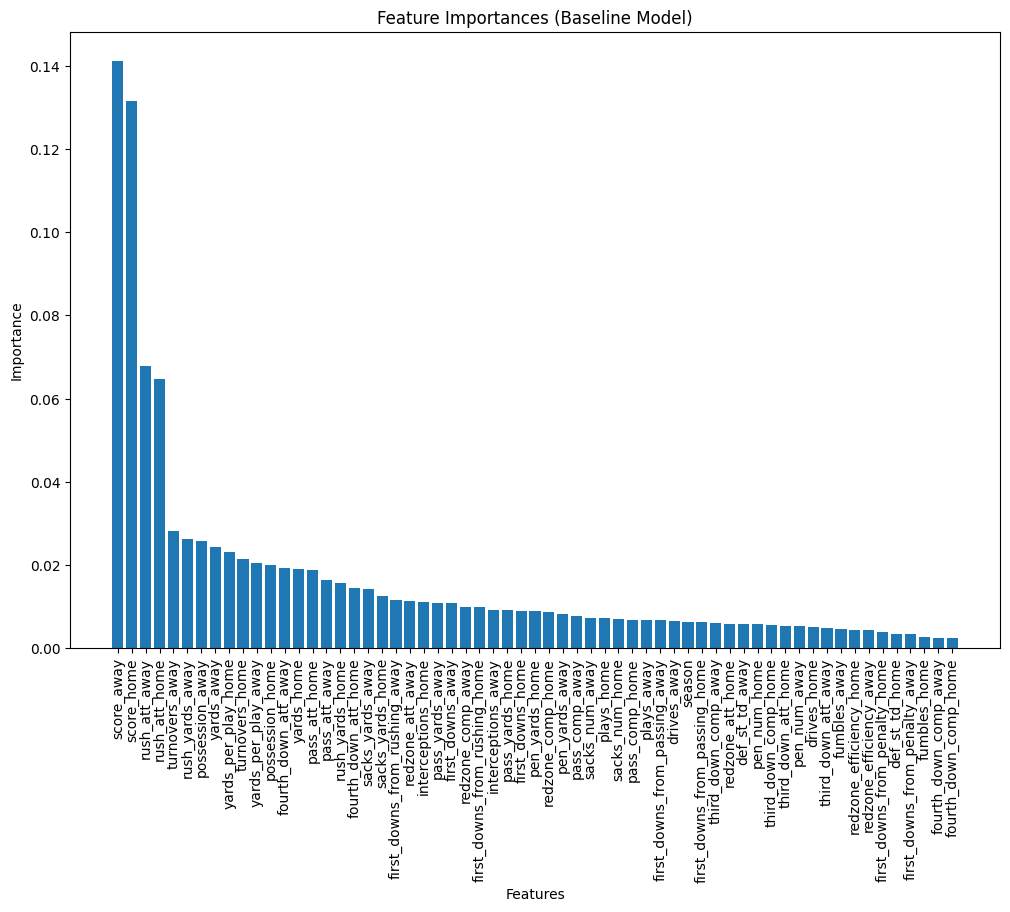

In [6]:
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1] #fancy indexing

plt.figure(figsize=(12, 8))
plt.bar(range(X.shape[1]), feature_importances[sorted_indices])
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.title("Feature Importances (Baseline Model)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

**Why score_home and score_away Seem Like Outliers?**

1. Direct Correlation with Task:
- The task is to predict win_loss_home (a binary outcome), which is inherently derived from the scores:
    - win_loss_home = 1 when score_home > score_away.
    - win_loss_home = 0 when score_home <= score_away.
- Since score_home and score_away directly determine the target variable, their importance is naturally higher than other features.
- Including them in the feature set introduces a form of "data leakage" because they directly encode the outcome we are trying to predict.

High Predictive Power:
- score_home and score_away inherently dominate the model’s decision-making because they are the strongest predictors of the win/loss outcome.
- This is expected since the task is essentially to predict which team scores more points—a direct function of the score features.

Reason for Excluding Scores:
- To understand what other factors contribute to win/loss outcomes, we exclude these score features. This allows the model to learn from other performance metrics (e.g., yards_per_play, turnovers) that indirectly influence the final scores and ultimately the outcome.

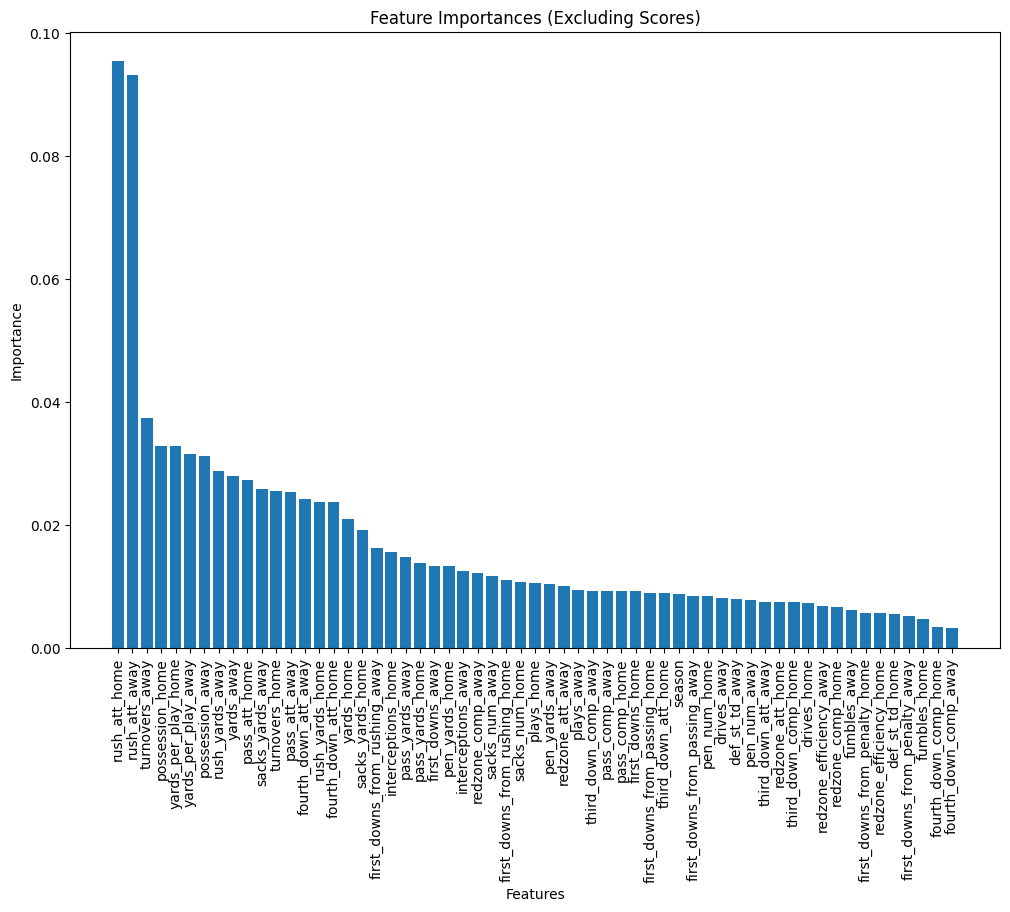

In [7]:
# Define features (X) excluding score_home and score_away
X_no_scores = data.drop(columns=['win_loss_home', 'away', 'home', 'week', 'score_home', 'score_away'])  # Exclude scores
y = data['win_loss_home']

# Scale features for interpretability
scaler = StandardScaler()
X_no_scores_scaled = scaler.fit_transform(X_no_scores)

# Train/test split, looked up straitfy as well
X_train, X_temp, y_train, y_temp = train_test_split(X_no_scores_scaled, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Train the Random Forest model
rf_model_no_scores = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model_no_scores.fit(X_train, y_train)

# Feature importance for the model excluding scores
feature_importances_no_scores = rf_model_no_scores.feature_importances_
sorted_indices_no_scores = np.argsort(feature_importances_no_scores)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.bar(range(X_no_scores.shape[1]), feature_importances_no_scores[sorted_indices_no_scores])
plt.xticks(range(X_no_scores.shape[1]), X_no_scores.columns[sorted_indices_no_scores], rotation=90)
plt.title("Feature Importances (Excluding Scores)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

Now, while the default Random Forest settings provide a good baseline, tuning hyperparameters (e.g., the number of trees, maximum depth, and maximum features) can optimize performance.

**Why?** 
Random Forest has many hyperparameters that impact how well it learns. For instance:
- Increasing n_estimators (number of trees) can improve performance but increases computational cost.
- Adjusting max_depth prevents overfitting or underfitting.
- Limiting max_features improves diversity among trees.

**How?** 
Use GridSearchCV or RandomizedSearchCV to systematically search for the best combination of parameters.

What is GridSearchCV?

GridSearchCV is a method provided by scikit-learn to search for the best combination of hyperparameters for a model.

Grid Search:
- It defines a grid of hyperparameter values.
- It trains and evaluates the model for every combination of hyperparameters in the grid.

Cross-Validation (CV):
- Instead of using a single train-test split, GridSearchCV evaluates each hyperparameter combination using k-fold cross-validation.

This helps ensure that the chosen hyperparameters generalize well to unseen data, reducing the risk of overfitting.

Goal: To find the combination of hyperparameters that optimizes a performance metric (e.g., accuracy, precision, F1-score) for your model.

Why Use GridSearchCV? 

in my research, it automates and selects the best parameters based on best performance; providing the best "settings" for our model

In [8]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for best split
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),  # Base model
    param_grid=param_grid,  # Hyperparameter grid
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1,  # Use all available processors for parallelism
    verbose=2   # Show detailed logs
)

# Train the GridSearchCV on the training set
grid_search.fit(X_train, y_train)

# Output the best hyperparameters
print("Best Parameters Found:")
print(grid_search.best_params_)

# Use the best model for further evaluation
best_rf_model = grid_search.best_estimator_

# Evaluate on the validation set
val_predictions = best_rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy with Best Model: {val_accuracy:.2f}")

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, val_predictions))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

remember, by cross-validating with GridSearchCV, it ensures the model's performance is not just tailored to a single train-test split

we can now evaluate results on the test set

In [8]:
test_predictions = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_predictions))

Test Accuracy: 0.93

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       484
           1       0.94      0.95      0.94       627

    accuracy                           0.93      1111
   macro avg       0.93      0.93      0.93      1111
weighted avg       0.93      0.93      0.93      1111



now in class, professor mentioned that the last step of the "machine learning process" is performance modeling.

I asked myself, how could we attack that? With some research, this is what I came up with: visualizing the test set confusion matrix to understand model performance.


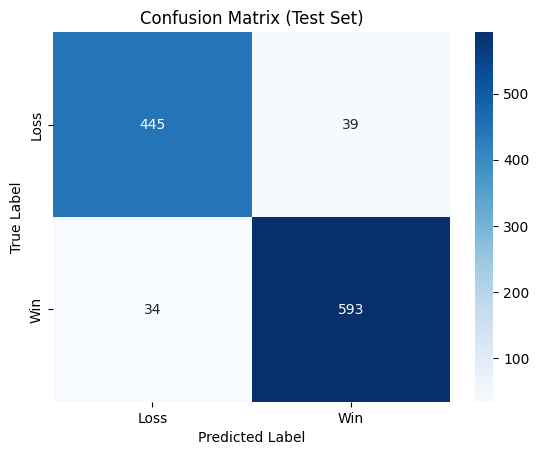

In [9]:
# Visualize test set confusion matrix to understand model performance.

conf_matrix = confusion_matrix(y_test, test_predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Hence, 
- True Positives (Wins Correctly Predicted): 593
- True Negatives (Losses Correctly Predicted): 445
- False Positives (Predicted Win but Was a Loss): 39
- False Negatives (Predicted Loss but Was a Win): 34

The model demonstrates strong performance, with an overall accuracy of approximately 93%. This indicates that the Random Forest model effectively predicts NFL team success, even when excluding direct score-related features.

## Feature Importance Analysis
The feature importance plot highlights the most significant factors contributing to win/loss outcomes for home teams. These are categorized into Offensive Metrics, Defensive Metrics, and Game Control Metrics, as follows:

***Offensive Metrics:***
- Rush 1st Downs (Home): (~9% importance)
    - The most influential metric. The ability of the home team to secure rushing first downs strongly correlates with sustained drives and scoring opportunities.

- Yards per Play (Home): (~7% importance)
    - A key efficiency metric. Teams that gain more yards per play tend to dominate offensively, leading to higher win probabilities.

- Pass Yards (Home): (~5% importance)
    - Passing yards reflect a team's air game success, a critical factor in modern NFL victories.

- Rush Yards (Home): (~4% importance)
    - Rushing yards highlight ground game effectiveness, which helps control the clock and wear down opposing defenses.

- Red Zone Efficiency (Home): (~3% importance)
    - Indicates the home team’s ability to convert red zone opportunities into touchdowns. Efficient red zone performance directly correlates with higher scoring potential.

***Defensive Metrics:***
- Turnovers (Away): (~5% importance)
    - Away team turnovers, including interceptions and fumbles, provide critical scoring opportunities for the home team.

- Defensive/Special Teams Touchdowns (Home): (~3% importance)
    - Game-changing defensive plays, such as pick-sixes or kickoff returns for touchdowns, significantly influence outcomes.

- Interceptions (Home): (~3% importance)
    - Defensive interceptions halt opponent drives and potentially create scoring opportunities for the home team.

***Game Control Metrics:***
- Possession Time (Home): (~3% importance)
    - Longer possession times allow the home team to control the pace of the game and limit opponent opportunities.

- First Downs (Home): (~2% importance)
    - The ability to consistently move the chains reflects offensive dominance and leads to sustained drives.

# What factors contribute most to team success (win/loss outcomes) in the NFL?

***Offensive Dominance:***
Metrics like rushing first downs, yards per play, and red zone efficiency are critical. Successful teams excel in both passing and rushing, ensuring efficient scoring.

***Defensive Opportunism:***
Turnovers by the away team and defensive touchdowns by the home team are key differentiators. These metrics highlight the importance of capitalizing on opponent mistakes.

***Game Control:***
Possession time and first downs indicate a team's ability to dictate the game flow. Teams that control the clock and sustain drives are more likely to win.

